In [14]:
### REMEMBER THAT THIS PRETRAINED MODEL DOESN'T HAVE THE SAME ARCHITECTURE AS THE BASELINE UNET, IT'S MUCH MORE COMPLEX AS IT'S IN THE LEADERBOARDS OF THE BRAIN CHALLENGE AND AS IT WAS TRAINED ON 32 GPUs
## Still, it might be interesting to compare performances


## R = 4

In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt 

reconstruction_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/PretrainedUNet/reconstructions/'
GT_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/multicoil_test_full/'
file = 'file_brain_AXT1_202_2020225.h5'

GT_path = os.path.join(GT_path,file)
reconstruction_path = os.path.join(reconstruction_path,file)

GT = h5py.File(GT_path, 'r')
reconstruction = h5py.File(reconstruction_path, 'r')


In [2]:
GT = GT['reconstruction_rss']
reconstruction = reconstruction['reconstruction']


In [3]:
GT = np.array(GT)
reconstruction = np.array(reconstruction)
reconstruction = reconstruction[:,0,:,:]


In [4]:
slice = 3


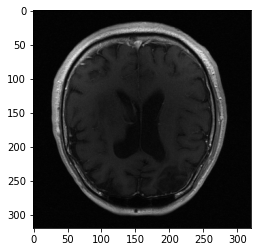

In [5]:
# Ground truth

plt.imshow(GT[slice,:,:],cmap='gray')


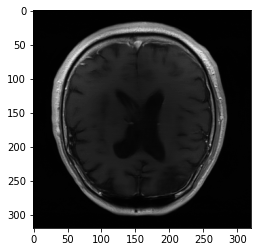

In [6]:
# Pretrained reconstruction

plt.imshow(reconstruction[slice,:,:],cmap='gray')


In [7]:
### DeepMRIRec version 3 - With optimized memory (so it now has LeakyReLU and uses batches of only 8 slices) AND trained without image augmentations

import os
import h5py
import random
from pygrappa import grappa
import matplotlib.pyplot as plt
from numpy import fft 
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Input,BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.layers import PReLU, LeakyReLU, add, Attention, Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

crop_size = (12,640,320)

model = None
kernel_size = (3,3)
loss_weights = [1.0, 0.0001, 0.000001]

selected_layers = ['block1_conv1', 'block2_conv2', 'block3_conv3' ,'block4_conv3']
selected_layer_weights_content = [0.001, 0.01, 2, 4]

vgg = VGG19(weights='imagenet', include_top=False, input_shape=(crop_size[1],crop_size[2],3))
vgg.trainable = False

outputs = [vgg.get_layer(l).output for l in selected_layers]
vgg_model = Model(vgg.input, outputs)
vgg_model.trainable = False

def model_loss_all(y_true, y_pred):
    global vgg_model
    global loss_weights
    global selected_layer_weights_content
    
    # Remove abs() from the ssim loss
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(img1=y_true,img2=y_pred,max_val=1.0,filter_size=3,filter_sigma=0.1))
    pixel_loss = tf.reduce_mean(tf.math.abs(y_true-y_pred))
    
    content_loss = 0.0
    res_y_rss = tf.image.grayscale_to_rgb(y_true*255)
    res_y_rss = preprocess_input(res_y_rss)
    vgg_f_gt = vgg_model(res_y_rss)

    res_y_pred = tf.image.grayscale_to_rgb(y_pred*255)
    res_y_pred = preprocess_input(res_y_pred)
    vgg_f_pred = vgg_model(res_y_pred)

    for h1, h2, cw in zip(vgg_f_gt, vgg_f_pred, selected_layer_weights_content):
        content_loss = content_loss + cw *tf.reduce_mean(tf.square(tf.math.abs(tf.cast(h1,tf.float32) - tf.cast(h2,tf.float32))))
    
    return loss_weights[0]*ssim_loss+loss_weights[1]*pixel_loss +loss_weights[2]*content_loss

def conv_block(ip, nfilters, drop_rate):
    
    layer_top = Conv2D(nfilters, (3,3), padding = "same")(ip)
    layer_top = BatchNormalization()(layer_top)

    res_model = LeakyReLU()(layer_top)
    res_model = Dropout(drop_rate)(res_model)
    
    res_model = Conv2D(nfilters, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization()(res_model)

    res_model = Dropout(drop_rate)(res_model)
    res_model = add([layer_top,res_model])
    res_model = LeakyReLU()(res_model)
    return res_model

def encoder(inp, nlayers, nbasefilters, drop_rate):
    
    skip_layers = []
    layers = inp
    for i in range(nlayers):
        layers = conv_block(layers,nbasefilters*2**i,drop_rate)
        
        # Attention layer
        #layers = Attention()([layers,layers])
        
        skip_layers.append(layers)
        layers = MaxPooling2D((2,2))(layers)
    return layers, skip_layers

def decoder(inp, nlayers, nbasefilters,skip_layers, drop_rate):
    
    layers = inp
    for i in range(nlayers):
        layers = conv_block(layers,nbasefilters*(2**(nlayers-1-i)),drop_rate)
        
        # Attention layer
        #layers=Attention()([layers,layers])
        
        layers=Conv2DTranspose(kernel_size=(2,2),filters=nbasefilters*(2**(nlayers-1-i)),strides=(2,2), padding='same')(layers)
        layers=add([layers,skip_layers.pop()])
    return layers

def create_gen(gen_ip, nlayers, nbasefilters, drop_rate):
    op,skip_layers = encoder(gen_ip,nlayers, nbasefilters,drop_rate)
    op = decoder(op,nlayers, nbasefilters,skip_layers,drop_rate)
    op = Conv2D(1, (3,3), padding = "same")(op)
    # Add sigmoid activation layer to force output images to have pixel values [0,1]
    op = Activation('sigmoid', dtype='float32')(op)
    return Model(inputs=gen_ip,outputs=op)

input_shape = (crop_size[1],crop_size[2],crop_size[0])
input_layer = Input(shape=input_shape)
model = create_gen(input_layer,5,32,0.01)


In [8]:
model.load_weights('/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Models/UnaugmentedExtensiveSaves/DeepMRIRec_trained_in_small_batches_GPU_epoch77.h5')


In [9]:
def calculate_mask(mask,start,end,nPE):
    '''
    The mask contains more information from the center of k-space. 
    We divide phase encoding space into nine areas/slots (see Figure 3 from paper, nine slots are separated by red dotted lines) 
    and select 10% of data points from the center area and 4%, 2%,1%, and 0.5% from the area adjacent to the centers
    In total, we thus retain 10% + (4+2+1+0.5)*2 % = 25% of the original k-space. This way, we obtain R=4.
    '''
    
    total_point = start
    max_len = nPE
    number_of_sample = (max_len/4)-(end-start)
    step = int((4*start)/number_of_sample)
    i = step
    f = 1
    indx = 1
    while i < total_point+1:
        offset = 10 + int(random.sample(range(0,3), 1)[0])
        if offset+i < total_point:
            mask[:,:,:,offset+i] = 1
        else:
            mask[:,:,:,i] = 1

        offset = 5 + int(random.sample(range(0,3), 1)[0])
        if i-offset > 0:
            mask[:,:,:,max_len-i-offset] = 1
        else:
            mask[:,:,:,max_len-i] = 1
        i = i+step
        indx = indx+1
        if i >= ((total_point*f)//2):
            step = int(step/3)
            f = f+1
    return mask

def Grappa_recon(kspace,start, end):
    calib = kspace[:,:,start:end].copy()
    res = grappa(kspace, calib, kernel_size=(5,5),coil_axis=0)
    return res

def comp_img(img,crop_size):
    s = img.shape
    start_height = s[1]//2 - (crop_size[1]//2)
    start_width = s[2]//2 - (crop_size[2]//2)
    return img[:,start_height:(start_height+crop_size[1]),start_width:(start_width+crop_size[2])]


In [10]:
last_mask = None
X_test = []
Y_test = []

with h5py.File(GT_path,'r') as f:

    k = f['kspace'][()]
    sequence = f.attrs['acquisition']
    nSL, nCh, nFE, nPE = k.shape
     
    # Select ACS region
    mid = nPE//2
    start = mid-int(nPE*0.05)
    end = mid+int(nPE*0.05)
       
    mask = 0*k
    mask[:,:,:,start:end] = 1
    mask = calculate_mask(mask,start,end,nPE)  
    last_mask = mask
    subsampled_k = k*mask
    ts = time.time()
    if nCh > 18:
        channels_picked = [0,1,2,4,7,8,11,13,15,16,17,18]
    elif nCh > 12 and nCh < 18:
        channels_picked = [0,1,2,3,4,5,6,7,8,10,11,12]
    else:
        channels_picked = []
    if len(channels_picked)>0:
        for slices in range(nSL): 
            chindx = 0
            ref_img = np.zeros((len(channels_picked),nFE,nPE),dtype=np.float32)
            sub_img = np.zeros((len(channels_picked),nFE,nPE),dtype=np.float32)
            subsampled_tmp = Grappa_recon(subsampled_k[slices,:,:,:],start,end)    
            for iCh in channels_picked:
                sub_img[chindx,:,:] = abs(fft.fftshift(fft.ifft2(subsampled_tmp[iCh,:,:])))
                ref_img[chindx,:,:] = abs(fft.fftshift(fft.ifft2(k[slices,iCh,:,:])))
                chindx = chindx+1
            X_test.append(list(comp_img(sub_img,crop_size)))
            Y_test.append(list(comp_img(ref_img,crop_size)))
        print(sequence,nSL,nCh,nFE,nPE,sub_img.shape,"ACS region indices: ",start,end,"Processing time: ", time.time()-ts)
X_test_arr = np.array(X_test).astype(np.float32)
Y_test_arr = np.array(Y_test).astype(np.float32)
print("X_test and Y_test constructed with shapes: ",X_test_arr.shape,Y_test_arr.shape)

X_test_arr = np.transpose(X_test_arr,(0,2,3,1))
Y_test_arr = np.transpose(Y_test_arr,(0,2,3,1))


Y_rss = np.sqrt(np.sum(np.square(Y_test_arr),axis=3))
Y_rss = Y_rss.astype(np.float32)

def normalize(I):
    mn = I.min()
    mx = I.max()

    mx -= mn

    #I = ((I - mn)/mx) * 255.0
    #return np.round(I).astype(np.uint8)
   
    I = ((I - mn)/mx)
    return I.astype(np.float32)

dims = X_test_arr.shape

for i in range(dims[0]):
    for j in range(dims[3]):
        X_test_arr[i,:,:,j] = normalize(X_test_arr[i,:,:,j])

for i in range(dims[0]):
    Y_rss[i,:,:] = normalize(Y_rss[i,:,:])


AXT1 16 16 640 320 (12, 640, 320) ACS region indices:  144 176 Processing time:  119.20902252197266
X_test and Y_test constructed with shapes:  (16, 12, 640, 320) (16, 12, 640, 320)


In [11]:
# Make prediction with our model

reconstructed_test_image = model.predict(X_test_arr)
reconstructed_test_image = reconstructed_test_image[:,:,:,0]


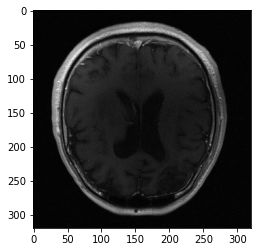

In [12]:
# Ground truth

Y_rss_cropped = comp_img(Y_rss,(None,320,320))
plt.imshow(Y_rss_cropped[slice,:,:], cmap='gray')


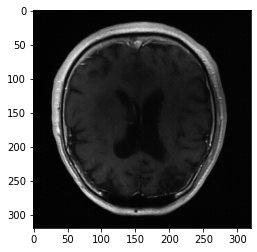

In [13]:
# DeepMRIRec reconstruction

reconstructed_test_image_cropped = comp_img(reconstructed_test_image,(None,320,320))
plt.imshow(reconstructed_test_image_cropped[slice,:,:], cmap='gray')


In [14]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from typing import Optional

def nmse(gt: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """Compute Normalized Mean Squared Error (NMSE)"""
    return np.array(np.linalg.norm(gt - pred) ** 2 / np.linalg.norm(gt) ** 2)

def psnr(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Peak Signal to Noise Ratio metric (PSNR)"""
    if maxval is None:
        maxval = gt.max()
    return peak_signal_noise_ratio(gt, pred, data_range=maxval)

def ssim(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Structural Similarity Index Metric (SSIM)"""
    if not gt.ndim == 3:
        raise ValueError("Unexpected number of dimensions in ground truth.")
    if not gt.ndim == pred.ndim:
        raise ValueError("Ground truth dimensions does not match pred.")

    maxval = gt.max() if maxval is None else maxval

    ssim = np.array([0])
    for slice_num in range(gt.shape[0]):
        ssim = ssim + structural_similarity(
            gt[slice_num], pred[slice_num], data_range=maxval
        )

    return ssim / gt.shape[0]

def ssim_tf(gt, pred, maxval=None):
    maxval = gt.max() if maxval is None else maxval
    gt_tf = tf.convert_to_tensor(gt)
    pred_tf = tf.convert_to_tensor(pred)
    ssim = tf.reduce_mean(tf.image.ssim(img1=gt_tf,img2=pred_tf,max_val=maxval,filter_size=3,filter_sigma=0.1))
    #ssim = tf.reduce_mean(tf.image.ssim(img1=gt_tf,img2=pred_tf,max_val=maxval))
    return ssim


In [15]:
# Pretrained model

print(nmse(GT,reconstruction))
print(psnr(GT,reconstruction))
print(ssim(GT,reconstruction))
print(ssim_tf(GT,reconstruction))

0.004184745011510851
39.85475637494843
[0.9609061]
tf.Tensor(0.9894287, shape=(), dtype=float32)


In [16]:
# DeepMRIRec model

print(nmse(Y_rss_cropped,reconstructed_test_image_cropped))
print(psnr(Y_rss_cropped,reconstructed_test_image_cropped))
print(ssim(Y_rss_cropped,reconstructed_test_image_cropped))
print(ssim_tf(Y_rss_cropped,reconstructed_test_image_cropped))

0.027421997372191358
30.21242593094094
[0.90362343]
tf.Tensor(0.96753234, shape=(), dtype=float32)


In [1]:
### Crucial difference!!!
# They apply statistical normalisation of their data during training and evaluation: (data - mean) / (stddev + eps)
# We apply min-max normalisation (also known as contrast normalisation) of the data during training and evaluation: (data - min) / (max - min)
